In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset directory path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Cholesteatoma/dataset/augmented_updated'


Mounted at /content/drive


In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Create a validation set
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Input size for VGG16
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Training subset
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Input size for VGG16
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation subset
)


Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
predictions = Dense(4, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)


In [5]:
for layer in base_model.layers:
    layer.trainable = False


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
]


In [8]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 369s 6s/step - accuracy: 0.2568 - loss: 7.9627 - val_accuracy: 0.3800 - val_loss: 6.8792 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 582ms/step - accuracy: 0.3210 - loss: 6.6406 - val_accuracy: 0.4425 - val_loss: 5.7870 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 584ms/step - accuracy: 0.3167 - loss: 5.6531 - val_accuracy: 0.4175 - val_loss: 4.9279 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 665ms/step - accuracy: 0.3483 - loss: 4.8102 - val_accuracy: 0.4475 - val_loss: 4.2267 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 677ms/step - accuracy: 0.3699 - loss: 4.1383 - val_accuracy: 0.4225 - val_loss: 3.6573 - learning_rate: 1.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 588ms/step - accuracy: 0.3630 - loss: 3.6183 - val_accuracy: 0.4900 - val_loss: 3.2096 - learning_rate: 1.0000e-04
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 584ms/step - accuracy: 0.3355

In [9]:
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 640ms/step - accuracy: 0.4277 - loss: 1.4579 - val_accuracy: 0.5425 - val_loss: 1.3621 - learning_rate: 1.0000e-05
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 607ms/step - accuracy: 0.4925 - loss: 1.3845 - val_accuracy: 0.5950 - val_loss: 1.2931 - learning_rate: 1.0000e-05
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 605ms/step - accuracy: 0.5310 - loss: 1.3235 - val_accuracy: 0.6300 - val_loss: 1.2513 - learning_rate: 1.0000e-05
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 599ms/step - accuracy: 0.5562 - loss: 1.2751 - val_accuracy: 0.6175 - val_loss: 1.2141 - learning_rate: 1.0000e-05
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - accuracy: 0.6058 - loss: 1.1877 - val_accuracy: 0.5850 - val_loss: 1.1873 - learning_rate: 1.0000e-05
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 617ms/step - accuracy: 0.6343 - loss: 1.1590 - val_accuracy: 0.5700 - val_loss: 1.1821 - learning_rate: 1.0000e-05
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - acc

**Save the Model**

In [10]:
model.save('/content/drive/MyDrive/Colab Notebooks/Cholesteatoma/vgg16.h5')


**Combine Histories for Plotting**

In [11]:
history.history['accuracy'] += fine_tune_history.history['accuracy']
history.history['val_accuracy'] += fine_tune_history.history['val_accuracy']
history.history['loss'] += fine_tune_history.history['loss']
history.history['val_loss'] += fine_tune_history.history['val_loss']


**Plot Accuracy and Loss**

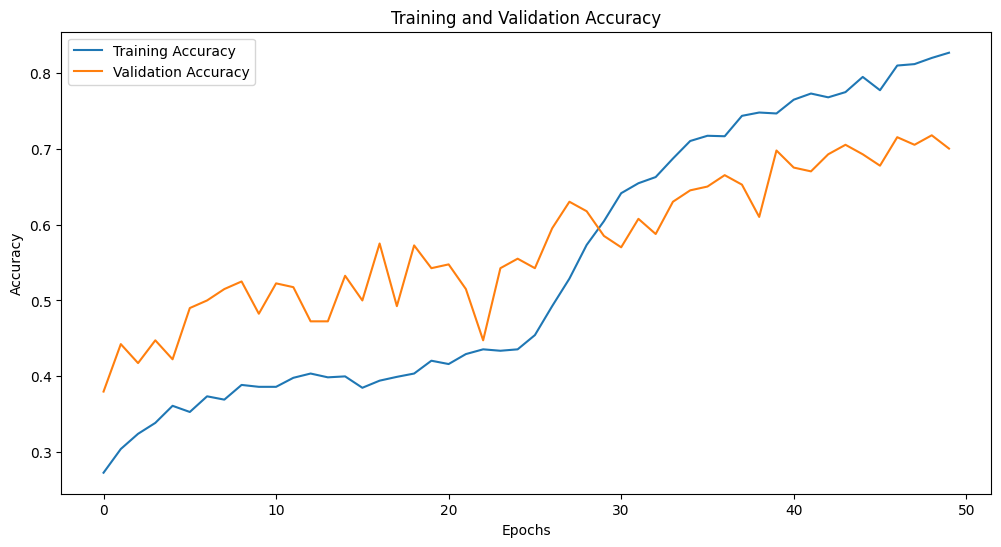

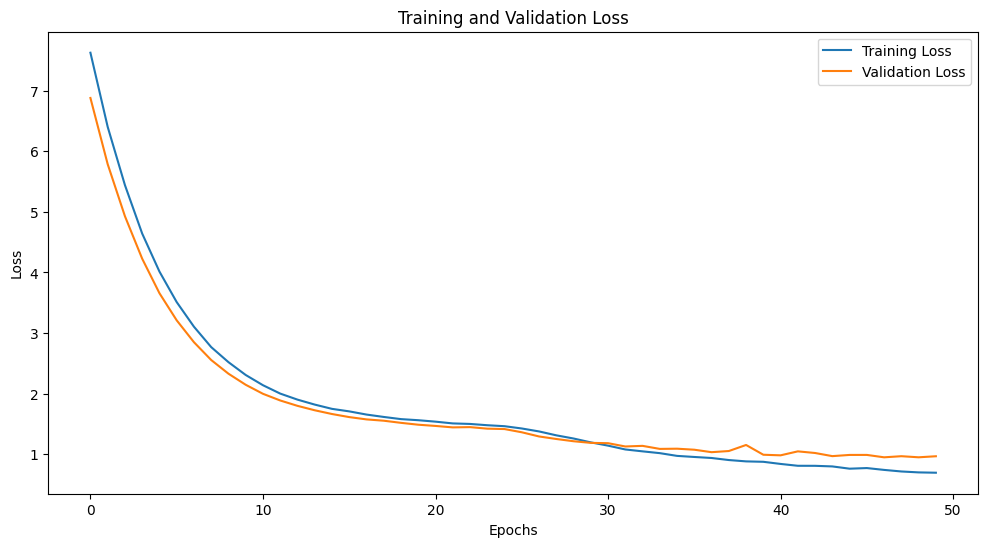

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
